In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=42)

In [3]:
# Create a dictionary containing B2B share (%) data per year and respective sources
b2b_data = {
    "year": [2009, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    "B2B (%)": [47, 43, 41, 39, 37, 35, 33, 32, 30, 25, 23, 24, 23],
    "Quelle": [
        "BIEK_KEP-Studie_2013",  # Source for 2009
        "BIEK_KEP-Studie_2013",  # Source for 2012
        "BIEK_KEP-Studie_2014",  # Source for 2013 (text reference)
        "BIEK_KEP-Studie_2015",
        "BIEK_KEP-Studie_2016",
        "BIEK_KEP-Studie_2017",
        "BIEK_KEP-Studie_2018",
        "BIEK_KEP-Studie_2019",
        "BIEK_KEP-Studie_2020",
        "BIEK_KEP-Studie_2021",
        "BIEK_KEP-Studie_2022",
        "BIEK_KEP-Studie_2023",
        "BIEK_KEP-Studie_2024"
    ]
}

# Convert the dictionary into a DataFrame
b2b_info = pd.DataFrame(b2b_data)

# Display the resulting DataFrame
b2b_info

,year,B2B (%),Quelle
0,2009,47,BIEK_KEP-Studie_2013
1,2012,43,BIEK_KEP-Studie_2013
2,2013,41,BIEK_KEP-Studie_2014
3,2014,39,BIEK_KEP-Studie_2015
4,2015,37,BIEK_KEP-Studie_2016
5,2016,35,BIEK_KEP-Studie_2017
6,2017,33,BIEK_KEP-Studie_2018
7,2018,32,BIEK_KEP-Studie_2019
8,2019,30,BIEK_KEP-Studie_2020
9,2020,25,BIEK_KEP-Studie_2021


In [4]:
# === Mathematical Model Functions ===

def exp_func(x, a, b):
    """
    Exponential function used for curve fitting.

    Inputs:
    -------
    x : array-like or float
        The independent variable (e.g., years shifted relative to 2009).
    a : float
        The scaling factor of the exponential curve.
    b : float
        The exponential growth/decay rate. Negative values indicate decay.

    Returns:
    --------
    float or array-like
        The exponential value computed as a * exp(b * x).
    """
    return a * np.exp(b * x)


def sigmoid(x, L, x0, k):
    """
    Sigmoid function used for logistic modeling.

    Inputs:
    -------
    x : array-like or float
        Independent variable.
    L : float
        The curve's maximum value (upper asymptote).
    x0 : float
        The x-value of the sigmoid’s midpoint (inflection point).
    k : float
        The logistic growth rate or steepness of the curve.

    Returns:
    --------
    float or array-like
        Value of the sigmoid function.
    """
    return L / (1 + np.exp(-k * (x - x0)))


def bounded_sigmoid(x, L, x0, k):
    """
    A sigmoid function bounded below by a constant (here, 20).

    Inputs:
    -------
    x : array-like or float
        Independent variable.
    L : float
        The maximum value the curve will approach (relative to lower bound).
    x0 : float
        The x-value where the sigmoid transitions most steeply.
    k : float
        Growth rate controlling the slope of the sigmoid.

    Returns:
    --------
    float or array-like
        Bounded sigmoid value (starts at C and increases toward C + L).
    """
    C = 20  # Lower bound of the function
    return C + (L / (1 + np.exp(-k * (x - x0))))


# === Confidence Interval Calculation ===

def get_confidence_interval(model_func, popt, x_vals, pcov, alpha=0.05):
    """
    Calculates confidence intervals for a fitted curve using the Jacobian and covariance.

    Inputs:
    -------
    model_func : callable
        The model function (e.g., exp_func, sigmoid, bounded_sigmoid) used for curve fitting.
    popt : array-like
        Optimal values for the parameters obtained from curve fitting.
    x_vals : array-like
        The independent variable values to evaluate the model on.
    pcov : 2D array
        Covariance matrix of the parameters from the curve fitting process.
    alpha : float, optional (default=0.05)
        Significance level for the confidence interval (1 - alpha is the confidence level).

    Returns:
    --------
    tuple of arrays:
        y_fit : array-like
            Fitted model values at each x_vals.
        lower : array-like
            Lower confidence bounds.
        upper : array-like
            Upper confidence bounds.
    """
    y_fit = model_func(x_vals, *popt)  # Calculate the fitted model values
    eps = 1e-8  # Small epsilon for numerical differentiation

    # Calculate Jacobian matrix numerically
    J = np.array([
        (model_func(x_vals, *(popt + eps * (np.arange(len(popt)) == i))) - y_fit) / eps
        for i in range(len(popt))
    ]).T

    # Estimate the variance at each x based on parameter covariance
    var_y = np.sum(J @ pcov * J, axis=1)
    sigma_y = np.sqrt(var_y)

    # 95% confidence interval multiplier (z = 1.96 for alpha = 0.05)
    ci = 1.96 * sigma_y

    lower = y_fit - ci
    upper = y_fit + ci
    return y_fit, lower, upper


# === Data Preparation ===

# Extract years and B2B percentage values from a DataFrame called b2b_info
years = b2b_info["year"].to_numpy()
b2b_values = b2b_info["B2B (%)"].to_numpy()

# Transform year values into relative x-values (relative to 2009 as baseline)
x = years - 2009
y = b2b_values


# === Curve Fitting ===

# Fit exponential model to data with initial guess a=47, b=-0.05
popt_exp, pcov_exp = curve_fit(exp_func, x, y, p0=(47, -0.05))

# Fit standard sigmoid function with initial parameters L=50, x0=6, k=-0.3
popt_sig, pcov_sig = curve_fit(sigmoid, x, y, p0=[50, 6, -0.3])

# Fit bounded sigmoid with initial parameters L=30, x0=6, k=-0.3
popt_bsig, pcov_bsig = curve_fit(bounded_sigmoid, x, y, p0=[30, 6, -0.3])


# === Forecast Extension ===

# Generate years from 2009 to 2050 (future values)
years_full = np.arange(2009, 2051)

# Convert years to relative x-values for forecasting
x_full = years_full - 2009

# Combine historical and forecast x-values
x_all = np.concatenate([x, x_full[len(x):]])
years_all = np.concatenate([years, years_full[len(years):]])

# Flag data as historical or forecast
is_forecast = np.array(["Data"] * len(x) + ["Forecast"] * (len(x_full) - len(x)))


# === Model Evaluation with Confidence Intervals ===

# Evaluate all models on combined x-values and calculate confidence intervals
y_exp, lo_exp, up_exp = get_confidence_interval(exp_func, popt_exp, x_all, pcov_exp)
y_sig, lo_sig, up_sig = get_confidence_interval(sigmoid, popt_sig, x_all, pcov_sig)
y_bsig, lo_bsig, up_bsig = get_confidence_interval(bounded_sigmoid, popt_bsig, x_all, pcov_bsig)


# === Create Output DataFrame for Visualization or Analysis ===

df_plot_b2b = pd.DataFrame({
    "Year": years_all,
    "Type": is_forecast,  # "Data" or "Forecast"
    "B2B_Exp": y_exp,
    "CI_Lower_Exp": lo_exp,
    "CI_Upper_Exp": up_exp,
    "B2B_Sigmoid": y_sig,
    "CI_Lower_Sigmoid": lo_sig,
    "CI_Upper_Sigmoid": up_sig,
    "B2B_BoundedSigmoid": y_bsig,
    "CI_Lower_BoundedSigmoid": lo_bsig,
    "CI_Upper_BoundedSigmoid": up_bsig,
})


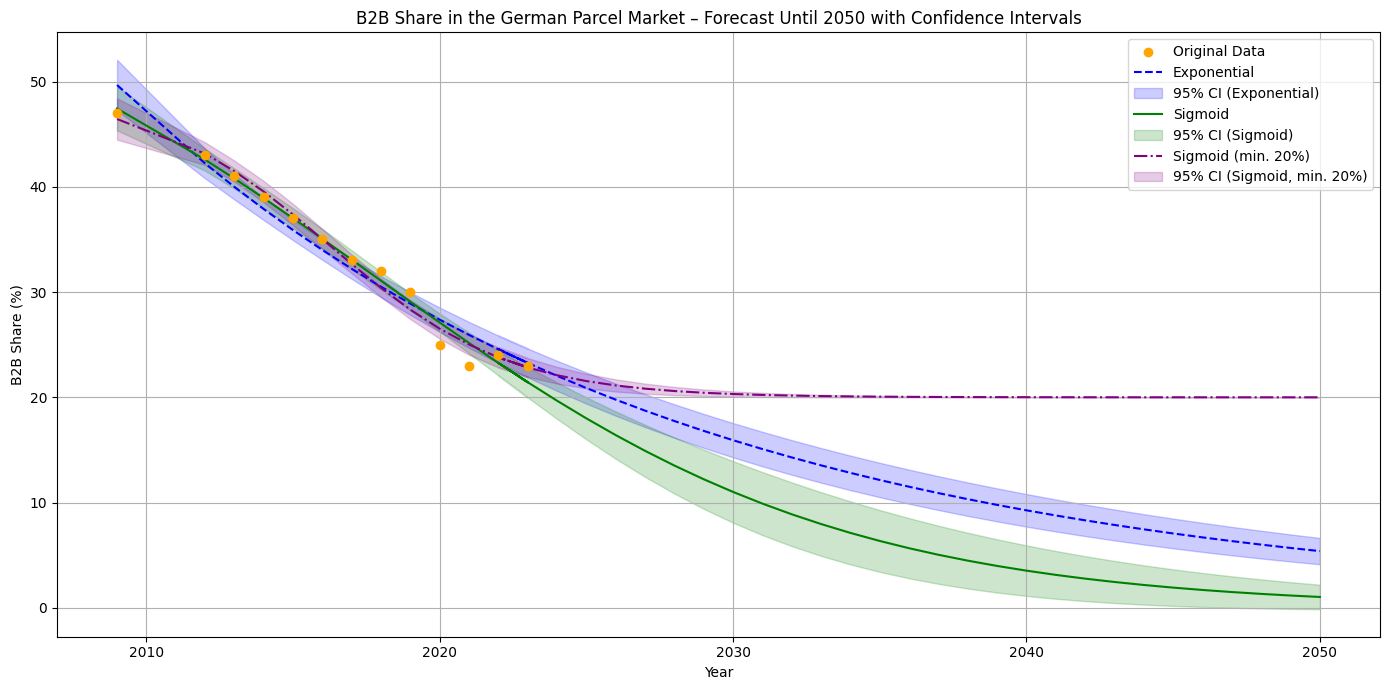

,Year,Type,B2B_Exp,CI_Lower_Exp,CI_Upper_Exp,B2B_Sigmoid,CI_Lower_Sigmoid,CI_Upper_Sigmoid,B2B_BoundedSigmoid,CI_Lower_BoundedSigmoid,CI_Upper_BoundedSigmoid
0,2009,Data,49.670263,47.276386,52.064141,47.435192,45.355890,49.514494,46.439020,44.480533,48.397506
1,2012,Data,42.218940,40.802657,43.635223,42.571366,41.527987,43.614746,43.148200,42.070563,44.225837
2,2013,Data,39.992413,38.791799,41.193028,40.783295,39.829116,41.737474,41.488409,40.486642,42.490176
3,2014,Data,37.883309,36.835707,38.930910,38.926535,37.984802,39.868268,39.542112,38.529538,40.554685
4,2015,Data,35.885433,34.925411,36.845455,37.012857,36.066279,37.959435,37.358307,36.343612,38.373002
5,2016,Data,33.992920,33.059380,34.926461,35.055705,34.122955,35.988455,35.025994,34.060119,35.991868
6,2017,Data,32.200214,31.244865,33.155564,33.069853,32.178019,33.961687,32.662747,31.766993,33.558502
7,2018,Data,30.502052,29.493254,31.510850,31.070976,30.231907,31.910046,30.392439,29.526484,31.258395
8,2019,Data,28.893446,27.814307,29.972585,29.075168,28.264367,29.885970,28.320383,27.423062,29.217704
9,2020,Data,27.369674,26.213783,28.525565,27.098424,26.246101,27.950747,26.515877,25.566961,27.464792


In [ ]:
# === Plotting Section ===

# Create a new figure with a defined size (14 inches wide by 7 inches tall)
plt.figure(figsize=(14, 7))

# --- Plot original data points ---
# These are the actual B2B percentage values per year from the dataset
plt.scatter(
    years,                   # X-values: actual years from the dataset
    b2b_values,              # Y-values: actual B2B percentage values
    label="Original Data",   # Legend label
    color="orange",          # Point color
    zorder=5                 # Ensures these points appear above other plot elements
)

# --- Plot Exponential Fit with Confidence Interval ---
plt.plot(
    years_all,                         # X-axis: full range including forecast years
    df_plot_b2b["B2B_Exp"],            # Y-axis: predicted B2B using exponential model
    label="Exponential",              # Legend label
    linestyle="--",                    # Dashed line for visual distinction
    color="blue"                       # Line color
)
plt.fill_between(
    years_all,                         # X-axis range
    df_plot_b2b["CI_Lower_Exp"],       # Lower bound of 95% confidence interval
    df_plot_b2b["CI_Upper_Exp"],       # Upper bound of 95% confidence interval
    alpha=0.2,                          # Transparency for shaded region
    color="blue",                       # Fill color
    label="95% CI (Exponential)"       # Legend label
)

# --- Plot Standard Sigmoid Fit with Confidence Interval ---
plt.plot(
    years_all,
    df_plot_b2b["B2B_Sigmoid"],
    label="Sigmoid",
    linestyle="-",
    color="green"
)
plt.fill_between(
    years_all,
    df_plot_b2b["CI_Lower_Sigmoid"],
    df_plot_b2b["CI_Upper_Sigmoid"],
    alpha=0.2,
    color="green",
    label="95% CI (Sigmoid)"
)

# --- Plot Modified (Bounded) Sigmoid Fit with Confidence Interval ---
plt.plot(
    years_all,
    df_plot_b2b["B2B_BoundedSigmoid"],
    label="Sigmoid (min. 20%)",    # Indicates bounded sigmoid with a 20% lower limit
    linestyle="-.",                 # Dash-dot line style
    color="purple"
)
plt.fill_between(
    years_all,
    df_plot_b2b["CI_Lower_BoundedSigmoid"],
    df_plot_b2b["CI_Upper_BoundedSigmoid"],
    alpha=0.2,
    color="purple",
    label="95% CI (Sigmoid, min. 20%)"
)

# --- Configure Axes and Labels ---
plt.xlabel("Year")                   # X-axis label
plt.ylabel("B2B Share (%)")          # Y-axis label
plt.title(
    "B2B Share in the German Parcel Market – Forecast Until 2050 with Confidence Intervals"
)                                    # Chart title
plt.grid(True)                       # Enable grid for readability
plt.legend()                         # Show legend
plt.tight_layout()                   # Adjust layout to prevent overlap
plt.show()                           # Render the plot

# Display the full DataFrame containing model predictions and confidence intervals
df_plot_b2b


In [7]:
# === Fill Missing Years (2010 and 2011) via Interpolation ===

# Create a continuous range of years from 2009 to 2023 (inclusive)
years_complete = np.arange(2009, 2024)

# Transform the year values to x-values relative to base year 2009
x_complete = years_complete - 2009


# --- Interpolate missing data points ---
# Use linear interpolation to estimate missing B2B values (for 2010 and 2011)
# from the known actual values (x, y)
interp_func = np.interp(x_complete, x, y)

# Store interpolated (and actual) values in a new array
istwerte_complete = interp_func.copy()


# --- Label data as 'Real' or 'Interpolated' ---
# Create an array indicating whether each year is original ("Data") or interpolated
ist_typ = np.where(np.isin(years_complete, years), "Data", "Interpolated")


# === Extend Forecast from 2024 to 2050 ===

# Create array for future forecast years
years_forecast = np.arange(2024, 2051)
x_forecast = years_forecast - 2009  # Transform to x-values relative to 2009


# === Combine Historical + Forecast Years and Data ===

# Combine historical and future years
years_all_fixed = np.concatenate([years_complete, years_forecast])

# Combine corresponding x-values
x_all_fixed = np.concatenate([x_complete, x_forecast])

# Combine data type labels ("Data", "Interpolated", "Forecast")
typ_all_fixed = np.concatenate([
    ist_typ,
    ["Forecast"] * len(years_forecast)
])

# Combine B2B values: historical/interpolated + NaNs for future
istwerte_all = np.concatenate([
    istwerte_complete,
    [np.nan] * len(years_forecast)  # Future actual values are unknown
])


# === Recalculate Model Predictions on Complete x-Range ===

# Apply previously fitted models on the extended x-value array
y_exp_all = exp_func(x_all_fixed, *popt_exp)
y_sig_all = sigmoid(x_all_fixed, *popt_sig)
y_bsig_all = bounded_sigmoid(x_all_fixed, *popt_bsig)


# === Create Final DataFrame with Complete History + Forecast ===

df_b2b_results_fixed = pd.DataFrame({
    "Year": years_all_fixed,             # Full range: 2009–2050
    "Actual_B2B": istwerte_all,          # Interpolated or original values until 2023
    "Type": typ_all_fixed,               # "Data", "Interpolated", or "Forecast"
    "B2B_Exp": y_exp_all,                # Predicted by exponential model
    "B2B_Sigmoid": y_sig_all,            # Predicted by sigmoid model
    "B2B_BoundedSigmoid": y_bsig_all,    # Predicted by bounded sigmoid model
})

# Display the DataFrame
df_b2b_results_fixed


,Year,Actual_B2B,Type,B2B_Exp,B2B_Sigmoid,B2B_BoundedSigmoid
0,2009,47.000000,Data,49.670263,47.435192,46.439020
1,2010,45.666667,Interpolated,47.050772,45.904075,45.596362
2,2011,44.333333,Interpolated,44.569426,44.280894,44.511254
3,2012,43.000000,Data,42.218940,42.571366,43.148200
4,2013,41.000000,Data,39.992413,40.783295,41.488409
5,2014,39.000000,Data,37.883309,38.926535,39.542112
6,2015,37.000000,Data,35.885433,37.012857,37.358307
7,2016,35.000000,Data,33.992920,35.055705,35.025994
8,2017,33.000000,Data,32.200214,33.069853,32.662747
9,2018,32.000000,Data,30.502052,31.070976,30.392439


In [ ]:
# Export the DataFrame to a CSV file
df_b2b_results_fixed.to_csv("output/01_b2b_forecast_complete.csv", index=False)